In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
import plotly
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True)

In [3]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [4]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [5]:
from models.CRNN import CRNN_model

# 1. Data

In [6]:
strategy = CommodityStrategy(strategy_name="CPM", asset_type="COMMODITY")
strategy.load_index_and_return(from_db=True, save_file=True)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2020-02-04 15:27:37,339 - CPM - INFO - [STEP 0] START LOGGING CPM
2020-02-04 15:27:37,343 - CPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:27:37,344 - CPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:27:37,356 - CPM - INFO - [STEP 1 - 2] GET DATA FROM BLOOM DATABASE
2020-02-04 15:27:50,987 - CPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:28:02,421 - CPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:28:45,117 - CPM - INFO - [STEP 1 - 4] SAVE RETURN DATA INTO CSV FORMAT


In [7]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

In [8]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

In [9]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

In [10]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 252]

# 1. FEATURE

### average return

In [11]:
avg_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_ret['avg_ret_' + str(period)] = df_index_return.rolling(period).mean()

### average vol

In [12]:
avg_vol  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_vol['avg_vol_' + str(period)] = df_index_return.rolling(period).std()

### cum return

In [13]:
cum_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    cum_ret['cum_ret_' + str(period)] = df_index.pct_change(period)

In [14]:
df_mom_avg_ret = pd.concat(avg_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_avg_vol = pd.concat(avg_vol, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_cum_ret = pd.concat(cum_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

# 2. 성과

# CASE 0. 기존(머신러닝 사용 X)

In [15]:
from CPM import CPM

In [ ]:
cpm = CPM(strategy_name="CPM", asset_type="COMMODITY")
cpm.load_index_and_return(from_db=True, save_file=True)
cpm.set_rebalance_period(ts_freq='week', cs_freq='week', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6 
cpm.calculate_signal(CS=0.35, minobs=52, longlen=52, shortlen=17)
cpm.set_portfolio_parameter(cs_strategy_type='vol')
cpm.make_portfolio()

2020-02-04 15:28:46,393 - CPM - INFO - [STEP 0] START LOGGING CPM
2020-02-04 15:28:46,393 - CPM - INFO - [STEP 0] START LOGGING CPM
2020-02-04 15:28:46,394 - CPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:28:46,394 - CPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:28:46,396 - CPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:28:46,396 - CPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:28:46,398 - CPM - INFO - [STEP 1 - 2] GET DATA FROM BLOOM DATABASE
2020-02-04 15:28:46,398 - CPM - INFO - [STEP 1 - 2] GET DATA FROM BLOOM DATABASE
2020-02-04 15:28:57,098 - CPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:28:57,098 - CPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:29:07,112 - CPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:29:07,112 - CPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:29:45,863 - CPM - INFO - [STEP 1 - 4] SAVE RETURN DATA I

In [ ]:
start_date = '2011-01-01'
end_date = '2018-05-09'

# get r results
cpm_comp_df = pd.read_csv('../check/past/cpm.csv', header=0, index_col=0, parse_dates=True)
cpm_lag_comp_df = pd.read_csv('../check/past/cpm_lag.csv', header=0, index_col=0, parse_dates=True)

### 1. PYTHON & R

In [ ]:
tester = Tester(cpm)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False, use_bt=False)

In [ ]:
to_plot = (1.+ cpm_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [ ]:
one_month = 21
df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [ ]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [ ]:
df_mom_cum_ret.reset_index(inplace=True)
df_mom_avg_ret.reset_index(inplace=True)
df_mom_avg_vol.reset_index(inplace=True)

df_join = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2005-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2006-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [ ]:
def train_tree(train_x, train_y1, val_x, val_y1, max_depth=7, fraction=0.8, num_leaves=50, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, random_state=1, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': max_depth,
          'num_leaves': num_leaves,
          "learning_rate": learning_rate,
          "feature_fraction": fraction,
          "subsample": fraction,
          "verbosity": verbose,
          "metric": 'binary_logloss',
          'random_state': random_state
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [ ]:
model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=i+1)

In [ ]:
%matplotlib inline

In [ ]:
supply_demand_feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), df_train.columns[3:])), columns=['Value','Feature'])
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=supply_demand_feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
test_pred = model.predict(df_test_x.values)

In [ ]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [ ]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')
df_pred = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

In [ ]:
df_index_sub = df_index.loc['1994':]
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [ ]:
strategy.set_rebalance_period(ts_freq='week', cs_freq='week', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6 
strategy.set_portfolio_parameter(cs_strategy_type='vol')
strategy.make_portfolio()

### TEST

In [ ]:
tester1 = Tester(strategy)
tester1.set_period(start=start_date, end=end_date)
tester1.run(use_bt=False)

In [ ]:
to_plot['CS_ML'] = tester1.strategy.CS_result

In [ ]:
to_plot.iplot()

# CASE 2. 70% 강조

- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [ ]:
one_month = 21
df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 

In [ ]:
df_index_y_binary1 = df_index_rank > df_index_rank.shape[1] / 3 * 2
df_index_y_binary1 = df_index_y_binary1.astype(np.float32)
df_y = df_index_y_binary1.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [ ]:
df_join2 = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2005-12-31')]
df_val = df_join2.loc[(df_join2['tdate'] >= pd.to_datetime('2006-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join2.loc[df_join2['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [ ]:
model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=i+1)

In [ ]:
test_pred = model.predict(df_test_x.values)

In [ ]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

df_pred2 = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

In [ ]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3
df_pred_rank2 = df_pred2.rank(axis=1)
df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [ ]:
strategy2 = CPM(strategy_name="CPM", asset_type="COMMODITY")
strategy2.load_index_and_return(from_db=True, save_file=True)
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2
strategy2.set_portfolio_parameter(cs_strategy_type='vol')
strategy2.make_portfolio()

### TEST

In [ ]:
tester2 = Tester(strategy2)
tester2.set_period(start=start_date, end=end_date)
tester2.run(use_bt=False)

In [ ]:
to_plot['CS_ML_UPPER'] = tester2.strategy.CS_result

In [ ]:
to_plot.iplot()

In [ ]:
result = pd.concat([empm.CS_summary,
                    empm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary], axis=1)

In [ ]:
result

In [ ]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER']

# CASE 3. Case1을 Rolling으로 실행

In [47]:
val_rolling_one_year = ['2007-12-31',
                    '2008-12-31',
                    '2009-12-31',
                    '2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31']

In [48]:
test_rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [49]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [50]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.692985	valid_1's binary_logloss: 0.693074
[20]	training's binary_logloss: 0.692812	valid_1's binary_logloss: 0.693005
[30]	training's binary_logloss: 0.692626	valid_1's binary_logloss: 0.692918
[40]	training's binary_logloss: 0.692437	valid_1's binary_logloss: 0.692848
[50]	training's binary_logloss: 0.692259	valid_1's binary_logloss: 0.692799
[60]	training's binary_logloss: 0.692073	valid_1's binary_logloss: 0.692758
[70]	training's binary_logloss: 0.691894	valid_1's binary_logloss: 0.692709
[80]	training's binary_logloss: 0.69173	valid_1's binary_logloss: 0.692681
[90]	training's binary_logloss: 0.691559	valid_1's binary_logloss: 0.692639
[100]	training's binary_logloss: 0.691382	valid_1's binary_logloss: 0.692574
[110]	training's binary_logloss: 0.691216	valid_1's binary_logloss: 0.692544
[120]	training's binary_logloss: 0.691047	valid_1's binary_logloss: 0.692508
[130]	training's binary_

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.693048	valid_1's binary_logloss: 0.693136
[20]	training's binary_logloss: 0.692945	valid_1's binary_logloss: 0.693123
[30]	training's binary_logloss: 0.692839	valid_1's binary_logloss: 0.693115
[40]	training's binary_logloss: 0.692731	valid_1's binary_logloss: 0.6931
[50]	training's binary_logloss: 0.692626	valid_1's binary_logloss: 0.693091
[60]	training's binary_logloss: 0.692522	valid_1's binary_logloss: 0.693082
[70]	training's binary_logloss: 0.69242	valid_1's binary_logloss: 0.693082
[80]	training's binary_logloss: 0.692312	valid_1's binary_logloss: 0.693069
[90]	training's binary_logloss: 0.692207	valid_1's binary_logloss: 0.693065
[100]	training's binary_logloss: 0.692103	valid_1's binary_logloss: 0.69306
[110]	training's binary_logloss: 0.692005	valid_1's binary_logloss: 0.69305
[120]	training's binary_logloss: 0.691905	valid_1's binary_logloss: 0.693056
[130]	training's binary_logl

[620]	training's binary_logloss: 0.6875	valid_1's binary_logloss: 0.692572
[630]	training's binary_logloss: 0.687422	valid_1's binary_logloss: 0.692578
[640]	training's binary_logloss: 0.687348	valid_1's binary_logloss: 0.692573
[650]	training's binary_logloss: 0.687269	valid_1's binary_logloss: 0.692569
[660]	training's binary_logloss: 0.687193	valid_1's binary_logloss: 0.692566
[670]	training's binary_logloss: 0.687116	valid_1's binary_logloss: 0.692562
[680]	training's binary_logloss: 0.68704	valid_1's binary_logloss: 0.692558
[690]	training's binary_logloss: 0.686962	valid_1's binary_logloss: 0.692557
[700]	training's binary_logloss: 0.686891	valid_1's binary_logloss: 0.692557
[710]	training's binary_logloss: 0.68682	valid_1's binary_logloss: 0.692562
[720]	training's binary_logloss: 0.686744	valid_1's binary_logloss: 0.69256
[730]	training's binary_logloss: 0.686672	valid_1's binary_logloss: 0.692567
[740]	training's binary_logloss: 0.686603	valid_1's binary_logloss: 0.692568
[750

In [51]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([1.0000e+00, 1.0000e+01, 6.0000e+00, 1.6000e+01, 1.2000e+01,
        7.0000e+00, 2.3000e+01, 3.9000e+02, 5.8700e+02, 2.6300e+02,
        2.4300e+02, 7.4300e+02, 4.0200e+02, 1.8830e+03, 2.1163e+04,
        4.0450e+03, 8.6600e+02, 1.5400e+02, 9.5000e+01, 9.9000e+01,
        4.1000e+01, 2.7000e+01, 3.6000e+01, 4.2000e+01, 4.2000e+01,
        4.0000e+01, 3.0000e+01, 1.7000e+01, 5.0000e+00, 2.0000e+00]),
 array([0.46686822, 0.46909094, 0.47131365, 0.47353636, 0.47575908,
        0.47798179, 0.4802045 , 0.48242722, 0.48464993, 0.48687264,
        0.48909536, 0.49131807, 0.49354078, 0.4957635 , 0.49798621,
        0.50020892, 0.50243164, 0.50465435, 0.50687706, 0.50909978,
        0.51132249, 0.5135452 , 0.51576792, 0.51799063, 0.52021334,
        0.52243606, 0.52465877, 0.52688148, 0.5291042 , 0.53132691,
        0.53354962]),
 <a list of 30 Patch objects>)

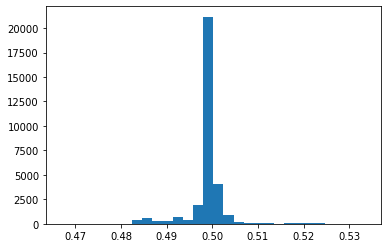

In [52]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [53]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [54]:
strategy3 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy3.load_index_and_return(from_db=False, save_file=False)
strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2019-11-21 16:38:20,220 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:38:20,220 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:38:20,220 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:38:20,220 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:38:20,222 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:38:20,222 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:38:20,222 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:38:20,222 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:38:20,223 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:38:20,223 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:38:20,223 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:38:20,223 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [55]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='month') 
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

2019-11-21 16:38:20,281 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:38:20,281 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:38:20,281 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:38:20,281 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:38:20,282 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:38:20,282 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:38:20,282 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:38:20,282 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:38:20,283 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:38:20,283 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:38:20,283 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:38:20,283 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:38:20,285 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-21 16:38:20,285 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-21 16:38:20,285 - EPM - INFO -

In [56]:
tester3 = Tester(strategy3)
tester3.set_period(start=start_date, end=end_date)
tester3.run()

2019-11-21 16:38:37,445 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:38:37,445 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:38:37,445 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:38:37,445 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:38:37,446 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:38:37,446 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:38:37,446 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:38:37,446 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:38:37,885 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:38:37,885 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:38:37,885 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:38:37,885 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


In [57]:
to_plot['CS_ML_ROLLING'] = tester3.strategy.CS_result

In [58]:
to_plot.iplot()

In [59]:
result = pd.concat([epm.CS_summary,
                    epm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary], axis=1)

In [60]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING']

In [61]:
result

,CS_python,TS_python,CS_ML,CS_ML_UPPER,CS_ML_ROLLING
TURNOVER,2.175536,0.834014,2.648424,2.437795,2.417866
MDD,-0.028668,-0.040567,-0.023505,-0.024790,-0.042354
CAGR,0.007017,0.002591,0.016806,0.017042,0.011905
CAGR_TR,-0.003191,-0.000753,0.004528,0.005102,0.002033
VOL,0.001356,0.001196,0.001398,0.001403,0.001439
SHARPE,0.329635,0.143223,0.747978,0.755706,0.519729
SHARPE_TR,-0.134812,-0.029428,0.211300,0.235784,0.099006


# CASE 4. CASE 2를 ROLLING으로 실행

In [62]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [63]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join2.loc[df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join2.loc[(df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.598071	valid_1's binary_logloss: 0.598169
[20]	training's binary_logloss: 0.597867	valid_1's binary_logloss: 0.598063
[30]	training's binary_logloss: 0.597668	valid_1's binary_logloss: 0.59794
[40]	training's binary_logloss: 0.597451	valid_1's binary_logloss: 0.597858
[50]	training's binary_logloss: 0.597253	valid_1's binary_logloss: 0.59776
[60]	training's binary_logloss: 0.597038	valid_1's binary_logloss: 0.597715
[70]	training's binary_logloss: 0.596843	valid_1's binary_logloss: 0.59765
[80]	training's binary_logloss: 0.596637	valid_1's binary_logloss: 0.597587
[90]	training's binary_logloss: 0.596435	valid_1's binary_logloss: 0.597516
[100]	training's binary_logloss: 0.596235	valid_1's binary_logloss: 0.597432
[110]	training's binary_logloss: 0.596047	valid_1's binary_logloss: 0.597386
[120]	training's binary_logloss: 0.595866	valid_1's binary_logloss: 0.597324
[130]	training's binary_lo

[670]	training's binary_logloss: 0.588998	valid_1's binary_logloss: 0.596873
[680]	training's binary_logloss: 0.58888	valid_1's binary_logloss: 0.596874
[690]	training's binary_logloss: 0.588755	valid_1's binary_logloss: 0.596876
[700]	training's binary_logloss: 0.588637	valid_1's binary_logloss: 0.596876
[710]	training's binary_logloss: 0.588524	valid_1's binary_logloss: 0.596871
[720]	training's binary_logloss: 0.588408	valid_1's binary_logloss: 0.596875
[730]	training's binary_logloss: 0.588277	valid_1's binary_logloss: 0.596853
[740]	training's binary_logloss: 0.588155	valid_1's binary_logloss: 0.596845
[750]	training's binary_logloss: 0.58803	valid_1's binary_logloss: 0.596845
[760]	training's binary_logloss: 0.587918	valid_1's binary_logloss: 0.596846
[770]	training's binary_logloss: 0.587802	valid_1's binary_logloss: 0.59685
[780]	training's binary_logloss: 0.58768	valid_1's binary_logloss: 0.59684
[790]	training's binary_logloss: 0.587564	valid_1's binary_logloss: 0.596846
[800

[830]	training's binary_logloss: 0.587492	valid_1's binary_logloss: 0.597631
[840]	training's binary_logloss: 0.587391	valid_1's binary_logloss: 0.597626
[850]	training's binary_logloss: 0.587288	valid_1's binary_logloss: 0.597628
[860]	training's binary_logloss: 0.587189	valid_1's binary_logloss: 0.597633
[870]	training's binary_logloss: 0.587092	valid_1's binary_logloss: 0.597633
[880]	training's binary_logloss: 0.586993	valid_1's binary_logloss: 0.597634
[890]	training's binary_logloss: 0.586901	valid_1's binary_logloss: 0.597637
[900]	training's binary_logloss: 0.586803	valid_1's binary_logloss: 0.597633
[910]	training's binary_logloss: 0.586704	valid_1's binary_logloss: 0.597626
[920]	training's binary_logloss: 0.58661	valid_1's binary_logloss: 0.597626
[930]	training's binary_logloss: 0.586513	valid_1's binary_logloss: 0.597624
[940]	training's binary_logloss: 0.586419	valid_1's binary_logloss: 0.597619
[950]	training's binary_logloss: 0.586328	valid_1's binary_logloss: 0.597617


[130]	training's binary_logloss: 0.596446	valid_1's binary_logloss: 0.597909
[140]	training's binary_logloss: 0.596316	valid_1's binary_logloss: 0.597885
[150]	training's binary_logloss: 0.596183	valid_1's binary_logloss: 0.597854
[160]	training's binary_logloss: 0.596055	valid_1's binary_logloss: 0.597827
[170]	training's binary_logloss: 0.595917	valid_1's binary_logloss: 0.597798
[180]	training's binary_logloss: 0.595789	valid_1's binary_logloss: 0.597777
[190]	training's binary_logloss: 0.595655	valid_1's binary_logloss: 0.597754
[200]	training's binary_logloss: 0.595516	valid_1's binary_logloss: 0.597732
[210]	training's binary_logloss: 0.595388	valid_1's binary_logloss: 0.597706
[220]	training's binary_logloss: 0.595253	valid_1's binary_logloss: 0.597678
[230]	training's binary_logloss: 0.595122	valid_1's binary_logloss: 0.59766
[240]	training's binary_logloss: 0.594995	valid_1's binary_logloss: 0.597636
[250]	training's binary_logloss: 0.594865	valid_1's binary_logloss: 0.59762
[

[1270]	training's binary_logloss: 0.584495	valid_1's binary_logloss: 0.596617
[1280]	training's binary_logloss: 0.584409	valid_1's binary_logloss: 0.596613
[1290]	training's binary_logloss: 0.58433	valid_1's binary_logloss: 0.596599
[1300]	training's binary_logloss: 0.584244	valid_1's binary_logloss: 0.596595
[1310]	training's binary_logloss: 0.584153	valid_1's binary_logloss: 0.596592
[1320]	training's binary_logloss: 0.584063	valid_1's binary_logloss: 0.596571
[1330]	training's binary_logloss: 0.583976	valid_1's binary_logloss: 0.596567
[1340]	training's binary_logloss: 0.583896	valid_1's binary_logloss: 0.596562
[1350]	training's binary_logloss: 0.583807	valid_1's binary_logloss: 0.596558
[1360]	training's binary_logloss: 0.583716	valid_1's binary_logloss: 0.59655
[1370]	training's binary_logloss: 0.583631	valid_1's binary_logloss: 0.596539
[1380]	training's binary_logloss: 0.583544	valid_1's binary_logloss: 0.596535
[1390]	training's binary_logloss: 0.583456	valid_1's binary_loglos

[850]	training's binary_logloss: 0.588876	valid_1's binary_logloss: 0.596637
[860]	training's binary_logloss: 0.588787	valid_1's binary_logloss: 0.596621
[870]	training's binary_logloss: 0.588685	valid_1's binary_logloss: 0.596617
[880]	training's binary_logloss: 0.588589	valid_1's binary_logloss: 0.596606
[890]	training's binary_logloss: 0.588497	valid_1's binary_logloss: 0.596589
[900]	training's binary_logloss: 0.588407	valid_1's binary_logloss: 0.596575
[910]	training's binary_logloss: 0.588309	valid_1's binary_logloss: 0.59656
[920]	training's binary_logloss: 0.588215	valid_1's binary_logloss: 0.596556
[930]	training's binary_logloss: 0.588123	valid_1's binary_logloss: 0.596543
[940]	training's binary_logloss: 0.588031	valid_1's binary_logloss: 0.596532
[950]	training's binary_logloss: 0.587942	valid_1's binary_logloss: 0.596511
[960]	training's binary_logloss: 0.587847	valid_1's binary_logloss: 0.596491
[970]	training's binary_logloss: 0.587753	valid_1's binary_logloss: 0.596484


[130]	training's binary_logloss: 0.596554	valid_1's binary_logloss: 0.597884
[140]	training's binary_logloss: 0.596432	valid_1's binary_logloss: 0.597856
[150]	training's binary_logloss: 0.596308	valid_1's binary_logloss: 0.597821
[160]	training's binary_logloss: 0.596187	valid_1's binary_logloss: 0.597801
[170]	training's binary_logloss: 0.596068	valid_1's binary_logloss: 0.597775
[180]	training's binary_logloss: 0.595949	valid_1's binary_logloss: 0.597754
[190]	training's binary_logloss: 0.595832	valid_1's binary_logloss: 0.597733
[200]	training's binary_logloss: 0.595707	valid_1's binary_logloss: 0.597711
[210]	training's binary_logloss: 0.595593	valid_1's binary_logloss: 0.597687
[220]	training's binary_logloss: 0.595479	valid_1's binary_logloss: 0.59766
[230]	training's binary_logloss: 0.595364	valid_1's binary_logloss: 0.59764
[240]	training's binary_logloss: 0.595253	valid_1's binary_logloss: 0.597619
[250]	training's binary_logloss: 0.595144	valid_1's binary_logloss: 0.597608
[

[1230]	training's binary_logloss: 0.586331	valid_1's binary_logloss: 0.596456
[1240]	training's binary_logloss: 0.586262	valid_1's binary_logloss: 0.596448
[1250]	training's binary_logloss: 0.586187	valid_1's binary_logloss: 0.596439
[1260]	training's binary_logloss: 0.586117	valid_1's binary_logloss: 0.596434
[1270]	training's binary_logloss: 0.586039	valid_1's binary_logloss: 0.596431
[1280]	training's binary_logloss: 0.585959	valid_1's binary_logloss: 0.59642
[1290]	training's binary_logloss: 0.585893	valid_1's binary_logloss: 0.59641
[1300]	training's binary_logloss: 0.58582	valid_1's binary_logloss: 0.596402
[1310]	training's binary_logloss: 0.585742	valid_1's binary_logloss: 0.596398
[1320]	training's binary_logloss: 0.585666	valid_1's binary_logloss: 0.596396
[1330]	training's binary_logloss: 0.585592	valid_1's binary_logloss: 0.59639
[1340]	training's binary_logloss: 0.58552	valid_1's binary_logloss: 0.596385
[1350]	training's binary_logloss: 0.585451	valid_1's binary_logloss: 

[360]	training's binary_logloss: 0.593719	valid_1's binary_logloss: 0.597606
[370]	training's binary_logloss: 0.593599	valid_1's binary_logloss: 0.5976
[380]	training's binary_logloss: 0.593492	valid_1's binary_logloss: 0.597584
[390]	training's binary_logloss: 0.593374	valid_1's binary_logloss: 0.597575
[400]	training's binary_logloss: 0.593273	valid_1's binary_logloss: 0.597563
[410]	training's binary_logloss: 0.593165	valid_1's binary_logloss: 0.597552
[420]	training's binary_logloss: 0.593053	valid_1's binary_logloss: 0.597547
[430]	training's binary_logloss: 0.592938	valid_1's binary_logloss: 0.597542
[440]	training's binary_logloss: 0.592834	valid_1's binary_logloss: 0.597533
[450]	training's binary_logloss: 0.592714	valid_1's binary_logloss: 0.597529
[460]	training's binary_logloss: 0.592604	valid_1's binary_logloss: 0.597529
[470]	training's binary_logloss: 0.592495	valid_1's binary_logloss: 0.597523
[480]	training's binary_logloss: 0.59239	valid_1's binary_logloss: 0.597516
[4

[1520]	training's binary_logloss: 0.583674	valid_1's binary_logloss: 0.597073
[1530]	training's binary_logloss: 0.583613	valid_1's binary_logloss: 0.597073
[1540]	training's binary_logloss: 0.583555	valid_1's binary_logloss: 0.597077
[1550]	training's binary_logloss: 0.583493	valid_1's binary_logloss: 0.597085
[1560]	training's binary_logloss: 0.583425	valid_1's binary_logloss: 0.597086
[1570]	training's binary_logloss: 0.583363	valid_1's binary_logloss: 0.597092
[1580]	training's binary_logloss: 0.583298	valid_1's binary_logloss: 0.597096
[1590]	training's binary_logloss: 0.583235	valid_1's binary_logloss: 0.5971
[1600]	training's binary_logloss: 0.583173	valid_1's binary_logloss: 0.597102
Early stopping, best iteration is:
[1501]	training's binary_logloss: 0.583797	valid_1's binary_logloss: 0.597063
Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.59813	valid_1's binary_logloss: 0.598258
[20]	training's binary_logloss: 0.597993	valid_1's

[540]	training's binary_logloss: 0.592126	valid_1's binary_logloss: 0.597459
[550]	training's binary_logloss: 0.592034	valid_1's binary_logloss: 0.59745
[560]	training's binary_logloss: 0.591941	valid_1's binary_logloss: 0.597447
[570]	training's binary_logloss: 0.591849	valid_1's binary_logloss: 0.597439
[580]	training's binary_logloss: 0.591758	valid_1's binary_logloss: 0.597429
[590]	training's binary_logloss: 0.591668	valid_1's binary_logloss: 0.597424
[600]	training's binary_logloss: 0.591585	valid_1's binary_logloss: 0.597427
[610]	training's binary_logloss: 0.591489	valid_1's binary_logloss: 0.597422
[620]	training's binary_logloss: 0.591401	valid_1's binary_logloss: 0.597411
[630]	training's binary_logloss: 0.591315	valid_1's binary_logloss: 0.597404
[640]	training's binary_logloss: 0.591225	valid_1's binary_logloss: 0.597401
[650]	training's binary_logloss: 0.59113	valid_1's binary_logloss: 0.597392
[660]	training's binary_logloss: 0.591043	valid_1's binary_logloss: 0.597378
[

In [64]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [65]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [66]:
strategy4 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy4.load_index_and_return(from_db=False, save_file=False)
strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2019-11-21 16:39:03,627 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:39:03,627 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:39:03,627 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:39:03,627 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:39:03,627 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-21 16:39:03,630 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:39:03,630 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:39:03,630 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:39:03,630 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:39:03,630 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-21 16:39:03,632 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:39:03,632 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:39:03,632 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:39:03,632 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-21 16:39:03,632 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [67]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='month') 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

2019-11-21 16:39:03,701 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:39:03,701 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:39:03,701 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:39:03,701 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:39:03,701 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-21 16:39:03,702 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:39:03,702 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:39:03,702 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:39:03,702 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:39:03,702 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-21 16:39:03,704 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:39:03,704 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:39:03,704 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:39:03,704 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-21 16:39:03,704 - EPM - INFO - [STE

In [68]:
tester4 = Tester(strategy4)
tester4.set_period(start=start_date, end=end_date)
tester4.run()

2019-11-21 16:39:21,531 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:39:21,531 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:39:21,531 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:39:21,531 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:39:21,531 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-21 16:39:21,534 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:39:21,534 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:39:21,534 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:39:21,534 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:39:21,534 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-21 16:39:22,126 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:39:22,126 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:39:22,126 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-11-21 16:39:22,126 - EPM - INFO - [STEP 6 - 2] BACKT

In [69]:
to_plot['CS_ML_UPPER_ROLLING'] = tester4.strategy.CS_result

In [70]:
to_plot.iplot()

In [71]:
result = pd.concat([epm.CS_summary,
                    epm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary,
                    strategy4.CS_summary], axis=1)

In [72]:
result

,0,1,2,3,4,5
TURNOVER,2.175536,0.834014,2.648424,2.437795,2.417866,3.205284
MDD,-0.028668,-0.040567,-0.023505,-0.024790,-0.042354,-0.020542
CAGR,0.007017,0.002591,0.016806,0.017042,0.011905,0.019606
CAGR_TR,-0.003191,-0.000753,0.004528,0.005102,0.002033,0.005457
VOL,0.001356,0.001196,0.001398,0.001403,0.001439,0.001363
SHARPE,0.329635,0.143223,0.747978,0.755706,0.519729,0.891555
SHARPE_TR,-0.134812,-0.029428,0.211300,0.235784,0.099006,0.258334


In [73]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING', 'CS_ML_UPPER_ROLING']

In [74]:
result

,CS_python,TS_python,CS_ML,CS_ML_UPPER,CS_ML_ROLLING,CS_ML_UPPER_ROLING
TURNOVER,2.175536,0.834014,2.648424,2.437795,2.417866,3.205284
MDD,-0.028668,-0.040567,-0.023505,-0.024790,-0.042354,-0.020542
CAGR,0.007017,0.002591,0.016806,0.017042,0.011905,0.019606
CAGR_TR,-0.003191,-0.000753,0.004528,0.005102,0.002033,0.005457
VOL,0.001356,0.001196,0.001398,0.001403,0.001439,0.001363
SHARPE,0.329635,0.143223,0.747978,0.755706,0.519729,0.891555
SHARPE_TR,-0.134812,-0.029428,0.211300,0.235784,0.099006,0.258334
